<font color="pink" size="7rem">可控制的</font>風格轉換
=============================
主要參考 : https://pytorch.org/tutorials/advanced/neural_style_tutorial.html<br>
作者 : 湯沂達 https://github.com/mistake0316
-------------
簡介
------------
<img src="https://i.imgur.com/q1vqGTq.png" width=50%/><br>
`A Neural Algorithm of Artistic Style <https://arxiv.org/abs/1508.06576>`<br>
是之前實作過的的基本風格轉換方法<br>
該方法有一個<font color="pink" size=6rem>可以</font>被改善的缺點：無法控制。<br>
在上圖中，假如直接對內容圖片(a)以及風格圖片(b)套上基本風格轉換演算法會得到圖(d)<br>
可以看到原本是雲朵的位置，它輸出結果變成圖(b)白色牆壁的樣式，而不是圖(b)的雲朵。

----
<img src="https://i.imgur.com/1boPlqDr.png"/>

`Controlling Perceptual Factors in Neural Style Transfer<https://arxiv.org/abs/1611.07865>`

同批作者在經過了一年後提出了改進方法，能夠控制
* 空間
* 顏色
* 尺度

來達成上圖的 (b), (c), (d) 的結果<br>
本記事本將實作`空間`以及`顏色`部分<br>
要達成上面兩個作法僅僅只需要細微改動即可。

In [ ]:
#@title 導入函式庫
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import plotly.express as px

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np
import cv2

import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title 下載影像
!rm -rf Neural-Style-Transfer
!git clone https://github.com/titu1994/Neural-Style-Transfer
!mv ./Neural-Style-Transfer/images/inputs ./images
!rm -rf Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1421 (delta 8), reused 12 (delta 4), pack-reused 1393
Receiving objects: 100% (1421/1421), 68.19 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [ ]:
!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
dataset, info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    with_info=True,
    split="test"
)
it = iter(dataset)
content_names = []
content_images = []
content_masks = []
for i in range(10):
  datapoint = next(it)
  content_names.append(datapoint['file_name'].numpy().decode())
  content_images.append(datapoint['image'].numpy())
  content_masks.append(datapoint['segmentation_mask'].numpy())

content_to_idx = {
    name : idx for idx, name in enumerate(content_names)
}
content_names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0NQ6X1/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0NQ6X1/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


['leonberger_73.jpg',
 'Maine_Coon_231.jpg',
 'saint_bernard_75.jpg',
 'saint_bernard_52.jpg',
 'beagle_98.jpg',
 'keeshond_88.jpg',
 'newfoundland_98.jpg',
 'yorkshire_terrier_24.jpg',
 'keeshond_78.jpg',
 'havanese_197.jpg']

In [ ]:
style_paths = os.listdir("images/style")
style_paths

['starry_night_crop.png',
 'bamboo_forest.jpg',
 'japanese_flower_sakai_hoitsu.jpg',
 'Blue Strokes.jpg',
 'water-lilies-1919-2.jpg',
 'metals',
 'starry_night.jpg',
 'woman-with-hat-matisse.jpg',
 'seated-nude.jpg',
 'japanese_painting.jpg',
 'the_scream.jpg',
 'escher_sphere.jpg',
 'misty-mood-leonid-afremov.jpg',
 'red-canna.jpg',
 'picasso_selfport1907.jpg',
 'blue_swirls.jpg',
 'frida_kahlo.jpg',
 'patterned_leaves.jpg',
 'wave_kanagawa.jpg',
 'shipwreck.jpg',
 'candy-style.jpg']

In [ ]:
# desired size of the output image
imsize = 512 #@param {type:"number"}

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_name = "beagle_98.jpg" #@param {type:"string"}
content_idx = content_to_idx[content_name]
make_n_times = lambda img, n=32: img[:img.shape[0]//n*n, :img.shape[1]//n*n, ...]
content_img = content_images[content_idx]
content_img = make_n_times(content_img)
content_img = Image.fromarray(content_img)
content_mask = content_masks[content_idx][...,0]
content_mask = make_n_times(content_mask)

style_foreground_path = "./images/style/picasso_selfport1907.jpg" #@param {type:"string"}
style_background_path = "./images/style/Blue Strokes.jpg" #@param {type:"string"}

content_img = loader(content_img).unsqueeze(0).to(device, torch.float)
content_mask = (
    torch.from_numpy(content_mask)
    .unsqueeze(0).unsqueeze(0) # H,W->B,C,H,W
    .to(device, torch.int)
)
style_foreground_img = image_loader(style_foreground_path)
style_background_img = image_loader(style_background_path)


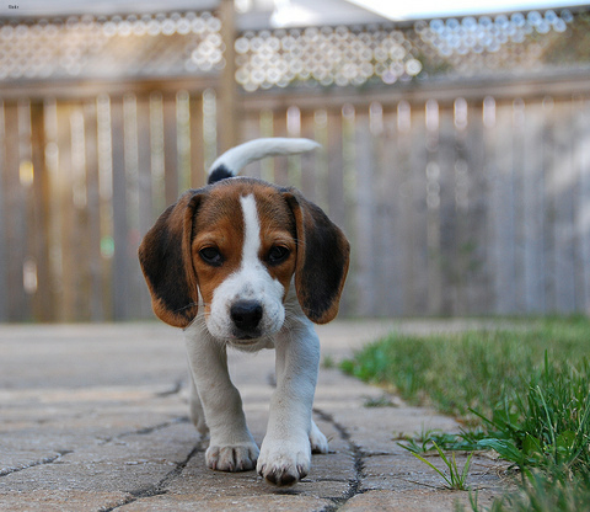

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    px.imshow(image, title=title).show()
    
imshow(content_img, title=f'Content Image: {content_name}')

# 空間控制
先回顧一下先前的演算法核心概念，<br>
要找到一個影像($I$)
1. 其特徵要跟內容影像($I_c$)相近
2. 其特徵的統計量要跟風格影像($I_s$)相近
---
<img src="https://i.imgur.com/OEDH0BN.png">

先回顧一下先前的演算法核心概念，<br>
要找到一個影像($I$)
1. 其特徵要跟內容影像($I_c$)相近
2. 其<font color="pink" size="6rem">指定區域</font>特徵的統計量要跟<font color="pink" size="6rem">指定</font>風格影像($I_s$)相近

若要達成此改動，要提供區域的遮罩<br>
以及在計算統計量時<font color="pink" size="4rem">對應區域</font>要使用<font color="pink" size="4rem">對應遮罩</font>下的損失函數<br>
可以參考上圖的標示
> (Ｇ是gram matrix，一種統計量的計算方式)

## 損失函數


### 內容損失函數
深層均方差

In [ ]:
# 與舊版相比不需變化
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.clone().detach()

    def forward(self, input):
        loss = F.mse_loss(input, self.target)
        return loss

### 風格損失函數
Gram Matrix的遮罩版本

In [ ]:
# 舊版
# def gram_matrix(input):
#   G = torch.einsum(
#       "bixy,bjxy->bij",
#       input,
#       input
#   )
#   return G/input.numel()

def gram_matrix(input, mask):
  # input shape : b, c, h, w
  # mask shape : b, 1, h, w
  masked_input = input*mask
  G = torch.einsum(
    "bixy,bjxy->bij",
    masked_input,
    masked_input
  )
  num_of_pixels = torch.einsum(
    "bixy->b", mask
  ).unsqueeze(1).unsqueeze(2)
  return G / (num_of_pixels*input.shape[1])

In [ ]:
# 舊版
# class StyleLoss(nn.Module):
#     def __init__(self, target_feature):
#         super(StyleLoss, self).__init__()
#         self.target = gram_matrix(target_feature).clone().detach()

#     def forward(self, input):
#         G = gram_matrix(input)
#         loss = F.mse_loss(G, self.target)
#         return loss

class StyleLoss(nn.Module):
    def __init__(self, target_feature, mask):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(
          target_feature,
          mask,
        ).clone().detach()

    def forward(self, input, mask):
        G = gram_matrix(input, mask)
        loss = F.mse_loss(G, self.target)
        return loss

## 特徵模型 VGG 19



In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG的前處理要將輸入經過平移、縮放<br>
平均值 : [0.485, 0.456, 0.406]<br>
標準差 : [0.229, 0.224, 0.225]




In [ ]:
# 與舊版無異
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1).clone().detach()
        self.std = std.view(-1, 1, 1).clone().detach()

    def forward(self, img):
        return (img - self.mean) / self.std

### 對應層名稱輸出


In [ ]:
set(list(map(type, cnn)))

{torch.nn.modules.activation.ReLU,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.pooling.MaxPool2d}

In [ ]:
# 與舊版無異
def get_feature(
    input,
    content_layers_name:list,
    style_layers_name:list,
  ):
  name_pool = set(style_layers_name) | set(content_layers_name)
  out_pool = dict()

  x = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)(input)
  block = 1
  layer = 0
  for l in cnn:
    if isinstance(l, nn.MaxPool2d):
      block += 1
      layer = 0
      name = f"pool_{block}"
    elif isinstance(l, nn.Conv2d):
      layer += 1
      name = f"conv{block}_{layer}"
    elif isinstance(l, nn.ReLU):
      name = f"relu{block}_{layer}"
    else:
      raise ValueError(f"{type(l)} should in MaxPool2d, Conv2d, ReLU")

    x = l(x)
    if name in name_pool:
      out_pool[name] = x
      name_pool.remove(name)
    
    if len(name_pool) == 0:
      break
  
  return {
      "content" : {name:out_pool[name] for name in content_layers_name},
      "style" : {name:out_pool[name] for name in style_layers_name},
  }

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv4_2']
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# 舊版
# def get_losses(content_img,style_img,
#               content_layers=content_layers_default,
#               style_layers=style_layers_default):
    
#     # just in order to have an iterable access to or list of content/syle
#     # losses

#     # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
#     # to put in modules that are supposed to be activated sequentially
#     content_losses = {
#       key:ContentLoss(value) for key, value in get_feature(content_img, content_layers,[])["content"].items()
#     }
    
#     style_losses = {
#       key:StyleLoss(value) for key, value in get_feature(style_img, [],style_layers)["style"].items()
#     }

#     # now we trim off the layers after the last content and style losses
#     return style_losses, content_losses

def get_losses(
    content_img,
    style_img_mask_list,
    content_layers=content_layers_default,
    style_layers=style_layers_default):
    
    # just in order to have an iterable access to or list of content/syle
    # losses

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    content_losses = {
      key:ContentLoss(value) for key, value in get_feature(content_img, content_layers,[])["content"].items()
    }
    

    style_losses_list = [
        {
          key:StyleLoss(
              value,
              # the hidden output size will become different, thus mask should be resized
              transforms.Resize(value.shape[2:])(mask)
          )
          for key, value in get_feature(style_img, [],style_layers)["style"].items()
        }
        for style_img, mask in style_img_mask_list
    ]

    # now we trim off the layers after the last content and style losses
    return style_losses_list, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




## 梯度下降


作者的建議是使用LBFGS 
> 原文網址：`https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq`

不過其實想要用什麼樣的優化器都可以。




In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img], lr=0.5)
    return optimizer

最後把所有東西打包成一個函式，其中我們除了內容、風格損失函數之外，額外新增了一個Total Variation Loss，其損失函數是相鄰像素的均方差。新增此損失函數可以避免相鄰像素變化太劇烈

In [ ]:
def run_style_transfer(
    content_img,
    style_img_mask_list,
    input_img,
    input_masks_list,
    num_steps=300,
    style_weight=1000000,
    content_weight=1,
    total_variation_weight=1000,
    content_layers=content_layers_default,
    style_layers=style_layers_default,
):
    """Run the style transfer."""
    assert len(input_masks_list) == len(style_img_mask_list)
    print('Building the style transfer model..')
    style_losses_list, content_losses = get_losses(
      content_img,
      style_img_mask_list,
      content_layers=content_layers,
      style_layers=style_layers
    )

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    cnn.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            features = get_feature(input_img, content_layers, style_layers)
            style_score = 0
            content_score = 0
            total_variation_score = 0.5*(
                ((input_img[:,:,:,:-1]-input_img[:,:,:,1:])**2).mean()
               +((input_img[:,:,:-1,:]-input_img[:,:,1:,:])**2).mean()
            )

            for name, feature in features["style"].items():
              for style_losses, mask in zip(style_losses_list, input_masks_list):
                # 因為卷積跟池化會讓影像大小變化，所以此處讓輸入遮罩等比例縮放
                mask = transforms.Resize(feature.shape[-2:])(mask)
                style_score += style_losses[name](feature, mask)
            
            for name, feature in features["content"].items():
              content_score += content_losses[name](feature)
            
            style_score *= style_weight
            content_score *= content_weight
            total_variation_score *= total_variation_weight

            loss = style_score + content_score + total_variation_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} Total Variation: {:4f}'.format(
                    style_score.item(), content_score.item(), total_variation_score.item()))
                imshow(input_img, title=f"step:{run[0]}")
                print()

            return style_score + content_score + total_variation_score

        optimizer.step(closure)

        # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


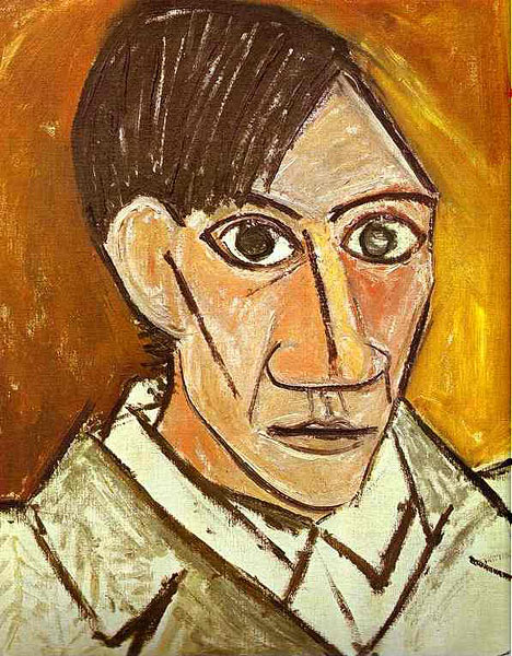


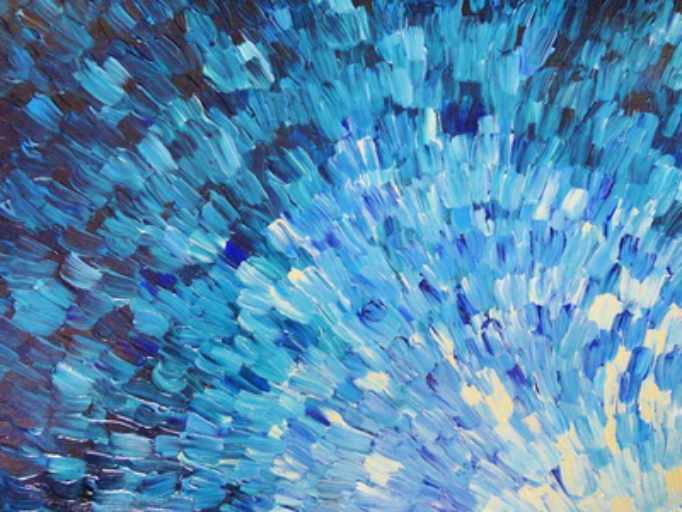

In [ ]:
imshow(style_foreground_img, "style_foreground_img")
imshow(style_background_img, "style_background_img")


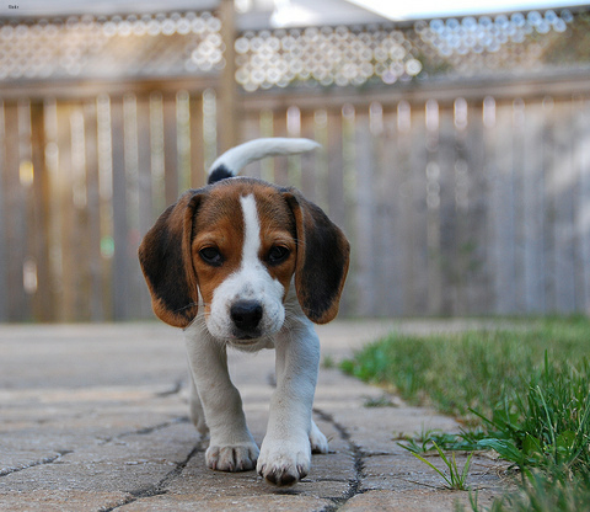

In [ ]:
input_img = content_img.clone()
imshow(input_img, title='Input Image')
px.imshow(
  content_mask.cpu().numpy()[0,0],
  title="mask: [1]foreground, [2]background, [3]boundary"
)

Finally, we can run the algorithm.




In [ ]:
full_mask_fun = lambda tensor: torch.ones(
  (1,1,*tensor.shape[-2:]),
  dtype=torch.float,
  device=device
)
output = run_style_transfer(
    content_img,
    [
                               # 我們用風格圖的全部像素來註冊統計量
        (style_foreground_img, full_mask_fun(style_foreground_img)),
        (style_background_img, full_mask_fun(style_background_img)),
    ],
    input_img,
    input_masks_list=[
        # 1,2,3 : (foreground, background, boundry)
        (content_mask==1).type(torch.float),
        (content_mask==2).type(torch.float),
    ],
    content_weight=1,
    style_weight=1000000,
    total_variation_weight=10000,
    num_steps=1500,
)

imshow(output, title='Output Image')

Output hidden; open in https://colab.research.google.com to view.

# 顏色控制
若想保留原始圖片顏色資訊，論文有提供兩種做法
1. 亮度轉換(Luminance-only transfer)
2. 顏色對齊(Colour histogram matching)

## 亮度轉換
亮度轉換的作法很簡單，先做一般的風格轉換後得到圖片，而後將此圖的<font size=5rem color=pink>亮度</font>貼回原圖上。


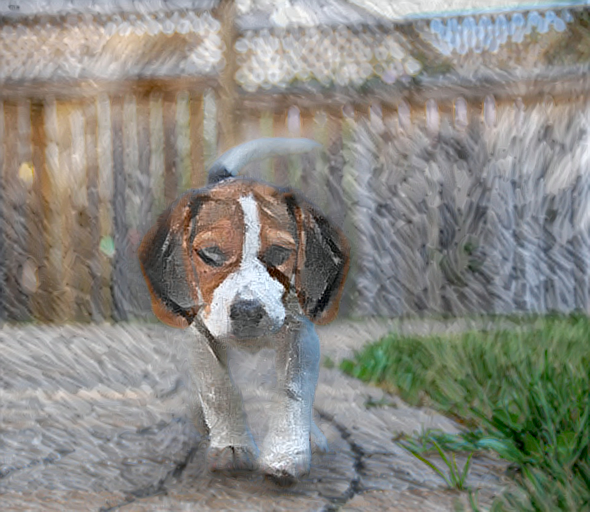

In [ ]:
torch_to_numpy_luv = lambda tensor:(
  cv2.cvtColor(
      np.asarray(transforms.ToPILImage()(tensor[0])),
      cv2.COLOR_RGB2LUV
  )
)

out_numpy_luv = torch_to_numpy_luv(output)
content_numpy_luv = torch_to_numpy_luv(content_img)

content_lunminance_change_luv = content_numpy_luv.copy()
content_lunminance_change_luv[..., 0] = out_numpy_luv[..., 0]
content_numpy_rgb = cv2.cvtColor(
    content_lunminance_change_luv,
    cv2.COLOR_LUV2RGB
)
px.imshow(content_numpy_rgb, title="亮度轉換")

## 顏色對齊
上方的亮度轉換版本，是先做完風格轉換，再調整原圖的亮度。<br>
而顏色匹配的演算法，是先用古典作法將風格圖片的顏色與內容圖像對齊，而後再套一般的風格轉換演算法。<br>
這邊就不實作了。

# 課後思考
1. 卷積層會在卷積以及池話的過程擴大感受野(receptive field)，單純的直接對遮罩放大縮小後去計算統計量會有問題，深層的統計量計算會使用遮罩外的資訊，在論文的補充有提供一些方法：
> 補充：http://bethgelab.org/media/uploads/stylecontrol/supplement/SupplementaryMaterial.pdf
2. 原始方法計算統計量時每一個位置都是一樣的權重。在此若遮罩大小不同，要怎麼改動才能達成此目的？
3. 尺度控制在我這份筆記本裡面沒提到，有興趣可以去研究原論文。